In [35]:
# -*- coding: utf-8 -*-
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # pandas is a library for handling datasets
import os # to move around your operating system
import scipy as sp  # scientific computation library
import random

from mpl_toolkits.mplot3d import axes3d # in case we need to plot in 3D z=f(x,y)
import seaborn as sns  # another package for pretty graphs

# Scikit-learn (sklearn) is a powerful and fairly comprehensive library of ML algorithms
from sklearn import datasets
from sklearn.neighbors.kde import KernelDensity
from sklearn.model_selection import train_test_split #Split arrays or matrices into random train and test subsets

np.random.seed(13) # a seed ensures that re-running the random number generator yields the same outcome
# this is helpful for the purpose of sanity checking your implementations

In [39]:
# 4 - generating synthetic data set
def f(x):
    y = []
    for i in range(len(x)):
        e = np.random.normal(0,0.1)
        y.append(np.sin(4*np.pi*x[i]) + e)
    return np.array(y)

# N points chosen randomly from 0 to 1
N = 1493
rn = np.random.uniform(0, 1, N) 
x = np.reshape(np.sort(rn, axis=0), (N, 1)) #sorts rn from low to high and converts array from 1xN to Nx1

In [41]:
# Rescaling data - x - centred about 0
x_scaled = x - x.mean()

#splitting scaled data into train and test sets
x_train_scaled, x_test_scaled = train_test_split(x_scaled, test_size=0.33, random_state=42)
x_train_scaled = np.sort(x_train_scaled, axis=0) #sorts x_train from low to high
x_test_scaled = np.sort(x_test_scaled, axis=0) #sorts x_test from low to high
print(len(x_train_scaled))

1000


In [42]:
#generating corresponding y components of scaled train and test sets
y_train_scaled = f(x_train_scaled) 
y_test_scaled =  f(x_test_scaled) 

In [45]:
# sampling from training set
def sample_training(data, B):
    # B = no of random samples taken from data
    sampled_input_data = []
    for i in range(B):
        x = random.choice(data) # randomly selected from data
        sampled_input_data.append(x)
        
    sampled_input_data = np.array(sampled_input_data)
    sampled_input_data = np.reshape(np.sort(sampled_input_data, axis=0), (B, 1)) #sorts rn from low to high and converts array from 1xN to Nx1
    sampled_output_data = f(sampled_input_data)
    #print(len(sampled_output_data))
    
    return sampled_input_data, sampled_output_data

In [46]:
# generating sampled data sets
ratio = 0.1 # sampling ratio

sampled_input_data = [] # array of sampled input data
sampled_output_data = [] # corresponding array of sampled output data

B = int(ratio*np.size(x_train_scaled)) # no of random samples taken from data

no_samples = int(1/ratio)
for i in range(no_samples):
    x = sample_training(x_train_scaled, B)
    sampled_input_data.append(x[0])
    sampled_output_data.append(x[1])

In [47]:
# 4.1 linear regression with polynomials and radial basis functions
def gauss_basis_fn(x, mu, sigma=0.1):
    return np.exp(-0.5 * (((mu - x) ** 2) / (sigma ** 2)))  #returns column of design matrix
      
def poly_basis_fn(x, degree):
    return x ** degree
    #returns column of design matrix corresponding to the entered degree

In [48]:
#defining design matrices

def poly_design(X, degree):
    A = poly_basis_fn(X, 1) #np.ones_like(X)
    for j in range(2, degree+1): # jth power of polynomial j = 1,...,p
        A = np.hstack((A, poly_basis_fn(X, j)))
    return A

def gauss_design(X, p):
    x_j = np.random.uniform(X[0], X[np.size(X)-1], p)
    x_j_learnt.append(x_j[0]) 
    A = gauss_basis_fn(X, x_j[0]) #np.ones_like(X)
    for j in range(1, p): # jth power of polynomial j = 1,...,p
        A = np.hstack((A, gauss_basis_fn(X, x_j[j])))
        x_j_learnt.append(x_j[j]) 
    return A

def gauss_design_test(X, p, x_j): 
    A = gauss_basis_fn(X, x_j[0]) #np.ones_like(X)
    for j in range(1, p): # jth power of polynomial j = 1,...,p
        A = np.hstack((A, gauss_basis_fn(X, x_j[j])))
    return A

In [49]:
# calculating min weights
def calc_weights(A, lamda, y):
    t1 = np.matmul(A.T, A)
    t2 = lamda*np.identity(len(A.T))
    t3 = np.linalg.inv(t1 + t2)
    t4 = np.matmul(A.T, y)
    w_min = np.matmul(t3, t4) #min loss
    return w_min

In [50]:
#calculate the mse and rmse 
def error(y, A, w_min):
    mse = np.square(y-np.matmul(A, w_min)).mean()
    rmse = mse**0.5
    return mse, rmse

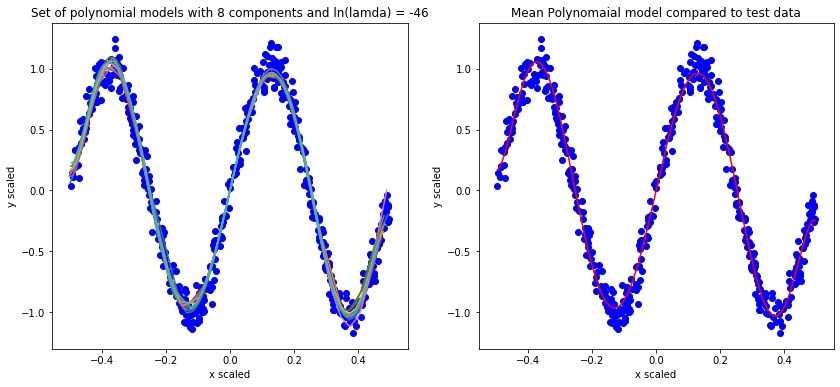

In [131]:
# plotting set of polynomial models and mean model

degree_poly = 7
lamda_poly = 10**(-20) # regularisation parameter
poly_weights = [] # list of sets of weights

fig, ax = plt.subplots(figsize=(14,6),nrows=1, ncols=2)

# plotting polynomials
ax[0].set(xlabel="x scaled", ylabel="y scaled", title = "Set of polynomial models with 8 components and ln(lamda) = %d" %np.log(lamda_poly))
ax[0].scatter(x_test_scaled, y_test_scaled, c='b', label='data')
ax[1].set(xlabel="x scaled", ylabel="y scaled", title = "Mean Polynomaial model compared to test data")
ax[1].scatter(x_test_scaled, y_test_scaled, c='b', label='data')

for i in range(no_samples):
    A_poly_train = poly_design(sampled_input_data[i], degree_poly) #design matrix of training data for ith model
    w_poly = calc_weights(A_poly_train, lamda_poly, sampled_output_data[i])
    poly_weights.append(w_poly)
    ax[0].plot(sampled_input_data[i], np.matmul(A_poly_train, w_poly))
    
# matrix of weights from each model- each column is one model's weights
poly_weights = np.array(poly_weights) # converting from list to nparray

poly_weights_mod = poly_weights[0] # stacking weights from each model into a matrix
for i in range(1, no_samples):
    poly_weights_mod = np.hstack((poly_weights_mod, poly_weights[i]))

#print(poly_weights_mod)

# average model's weights
poly_weights_average = np.array(np.sum(poly_weights_mod,axis=1).tolist()) # adding all the respective weights from each model
poly_weights_average = poly_weights_average/no_samples # finding the average of each weight over the ensemble of models
poly_weights_average = np.reshape(poly_weights_average, (degree_poly, 1)) #reshaping into column vector

A_poly_test = poly_design(x_test_scaled, degree_poly) #design matrix of test data
average_model = np.matmul(A_poly_test, poly_weights_average) # average model for the test data
ax[1].plot(x_test_scaled, average_model, c='r')



#print(type(A_poly_test))
#print(A_poly_test)
#print(len(x_test_scaled))

In [29]:
# calculate y_xn for a model
def y_xn(weights_mod, x_test_scaled, n, model, degree): 
        weights_mod_T = weights_mod.T # each models set of weights are in rows
        A_test = poly_design(x_test_scaled, degree_poly)
        y_xn = np.matmul(A_poly_test[n], weights_mod_T[model])
        
        return y_xn

#f = y_xn(poly_weights_mod, x_test_scaled, 0, 0,degree_poly)

In [30]:
# calculate y_bar_xn
def calc_ybar_xn(no_samples, poly_weights_mod, x_test_scaled, n, degree_poly):
    ybar_xn = 0
    for l in range(no_samples):
        ybar_xn = ybar_xn + y_xn(poly_weights_mod, x_test_scaled, n, l, degree_poly)
    
    return ybar_xn/no_samples

#print(calc_ybar_xn(no_samples, poly_weights_mod, x_test_scaled, 0, degree_poly))

In [31]:
# calculate bias
def calc_bias(no_samples, poly_weights_mod, x_test_scaled, degree_poly, y_test_scaled):
    dev_sq_sum = 0
    for n in range(len(x_test_scaled)):
        y_bar_xn = calc_ybar_xn(no_samples, poly_weights_mod, x_test_scaled, n, degree_poly)
        dev = y_bar_xn - y_test_scaled[n]
        dev_sq = dev**2
        dev_sq_sum = dev_sq_sum + dev_sq
    
    return dev_sq_sum/len(x_test_scaled)

#print(calc_bias(no_samples, poly_weights_mod, x_test_scaled, degree_poly, y_test_scaled))

In [32]:
# calculate variance
def calc_var(poly_weights_mod, x_test_scaled, degree_poly, no_samples):
    dev_sq_sum = 0
    dev_sq_sum_4all = 0
    for n in range(len(x_test_scaled)):
        y_bar_xn = calc_ybar_xn(no_samples, poly_weights_mod, x_test_scaled, n, degree_poly)
        
        for l in range(no_samples):
            y_xn_l = y_xn(poly_weights_mod, x_test_scaled, n, l, degree_poly)
            dev = y_xn_l - y_bar_xn
            dev_sq = dev**2
            dev_sq_sum = dev_sq_sum + dev_sq
        dev_sq_sum_4all = (dev_sq_sum_4all+dev_sq_sum)/no_samples
    
    return dev_sq_sum_4all/len(x_test_scaled)

#print(calc_var(poly_weights_mod, x_test_scaled, degree_poly, no_samples))

In [33]:
# calculating weights vs lamda
def weights_mod(no_samples, sampled_input_data, degree_poly, lamda_poly, sampled_output_data):
    poly_weights = []
    for i in range(no_samples):
        A_poly_train = poly_design(sampled_input_data[i], degree_poly) #design matrix of training data for ith model
        w_poly = calc_weights(A_poly_train, lamda_poly, sampled_output_data[i])
        poly_weights.append(w_poly)
    # matrix of weights from each model- each column is one model's weights
    poly_weights = np.array(poly_weights) # converting from list to nparray

    poly_weights_mod = poly_weights[0] # stacking weights from each model into a matrix
    for i in range(1, no_samples):
        poly_weights_mod = np.hstack((poly_weights_mod, poly_weights[i]))
        
    return poly_weights_mod

#print(weights_mod(no_samples, sampled_input_data, degree_poly, lamda_poly, sampled_output_data))

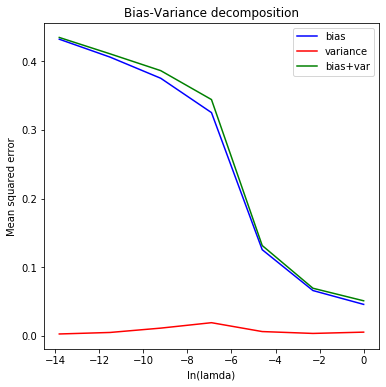

In [114]:
# plotting how bias and variance change w.r.t lamda

reg_param_poly = [10**(-i) for i in range(0, 7)]
reg_param_poly.reverse() #for calculating
log_reg_param_poly = [np.log(10**(-i)) for i in range(0,7)]
log_reg_param_poly.reverse() #for plotting

bias = []
var = []

for i in range(-1, 6):
    lamda_poly = 10**(-i-1)
    weights = weights_mod(no_samples, sampled_input_data, degree_poly, lamda_poly, sampled_output_data)
    bias_ind = calc_bias(no_samples, weights, x_test_scaled, degree_poly, y_test_scaled)
    bias.append(bias_ind)
    var_ind = calc_var(weights, x_test_scaled, degree_poly, no_samples)
    var.append(var_ind)


bias = np.array(bias)
var = np.array(var)

fig, ax = plt.subplots(figsize=(6,6),nrows=1, ncols=1)
ax.set(xlabel="ln(lamda)", ylabel="Mean squared error", title = "Bias-Variance decomposition")
ax.plot(log_reg_param_poly, bias, c='b', label='bias')
ax.plot(log_reg_param_poly, var, c='r', label='variance')

bias = bias.T
total = bias+var
total = total.T
ax.plot(log_reg_param_poly, total, c='g', label='bias+var')
ax.legend()

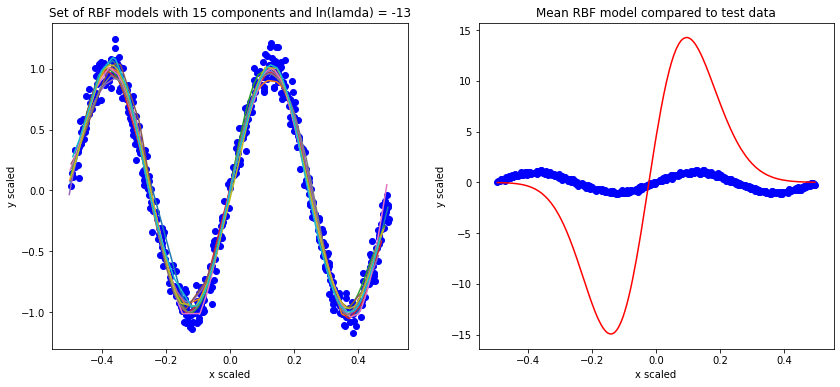

In [110]:
# plotting set of RBFs models and mean model

degree_gauss = 15
lamda_gauss = 10**(-6) # regularisation parameter
gauss_weights = [] # list of sets of weights

fig, ax = plt.subplots(figsize=(14,6),nrows=1, ncols=2)

# plotting gaussians
ax[0].set(xlabel="x scaled", ylabel="y scaled", title = "Set of RBF models with 15 components and ln(lamda) = %d" %np.log(lamda_poly))
ax[0].scatter(x_test_scaled, y_test_scaled, c='b', label='data')
ax[1].set(xlabel="x scaled", ylabel="y scaled", title = "Mean RBF model compared to test data")
ax[1].scatter(x_test_scaled, y_test_scaled, c='b', label='data')

x_j_learnt_final = []

for i in range(no_samples):
    x_j_learnt = []
    A_gauss_train = gauss_design(sampled_input_data[i], degree_gauss) #design matrix of training data for ith model
    if(i==0):
        x_j_learnt_final = x_j_learnt
        x_j_learnt_final = np.asarray(x_j_learnt_final)
        x_j_learnt_final = np.reshape(x_j_learnt_final, (15,1))
    x_j_learnt = np.asarray(x_j_learnt)
    x_j_learnt = np.reshape(x_j_learnt, (15,1))
    x_j_learnt_final = np.hstack((x_j_learnt_final, x_j_learnt))
    w_gauss = calc_weights(A_gauss_train, lamda_gauss, sampled_output_data[i])
    gauss_weights.append(w_gauss)
    ax[0].plot(sampled_input_data[i], np.matmul(A_gauss_train, w_gauss))
    #print(x_j_learnt, "\n")    

# average model's weights
means = np.asarray(np.sum(x_j_learnt_final,axis=1).tolist()) # adding all the respective weights from each model
means = means/no_samples # finding the average of each weight over the ensemble of models
#means = np.reshape(means, (1, 15)) #reshaping into column vector
means = list(means)

# matrix of weights from each model- each column is one model's weights
gauss_weights = np.asarray(gauss_weights) # converting from list to nparray

gauss_weights_mod = gauss_weights[0] # stacking weights from each model into a matrix
for i in range(1, no_samples):
    gauss_weights_mod = np.hstack((gauss_weights_mod, gauss_weights[i]))


#print(gauss_weights_mod)

# average model's weights
gauss_weights_average = np.asarray(np.sum(gauss_weights_mod,axis=1).tolist()) # adding all the respective weights from each model
gauss_weights_average = gauss_weights_average/no_samples # finding the average of each weight over the ensemble of models
gauss_weights_average = np.reshape(gauss_weights_average, (degree_gauss, 1)) #reshaping into column vector

A_gauss_test = gauss_design_test(x_test_scaled, degree_gauss, means) #design matrix of test data
#print(A_gauss_test)
average_model2 = np.matmul(A_gauss_test, gauss_weights_average) # average model for the test data

ax[1].plot(x_test_scaled, average_model2, c='r')


#print(type(A_poly_test))
#print(A_poly_test)
#print(len(x_test_scaled))